# LSTM Analysis

In [1]:
import h5py
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow

plt.style.use('fivethirtyeight')

Using TensorFlow backend.
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lucas/.local/lib/python3.6/site-packages/tensorflow/python/fra

## Read dataset

In [2]:
dataset_file = "../data/users.h5"
users_df = pd.read_hdf(dataset_file)
users_df = pd.DataFrame(users_df.to_records())
users_df = users_df
users_df


,time_hour,0,1,2,3,10,11,12,13,20,...,972,973,980,982,983,990,991,992,993,99300
0,2012-08-18 16:00:00,103,32,35,36,1919,667,610,642,1694,...,20,47,32,11,21,609,208,194,207,161282
1,2012-08-18 17:00:00,78,31,20,27,1348,462,429,457,1226,...,15,37,16,7,9,377,136,126,115,108600
2,2012-08-18 18:00:00,36,17,9,10,914,304,286,324,929,...,10,28,14,5,9,212,88,70,54,77076
3,2012-08-18 19:00:00,32,14,7,11,653,210,208,235,799,...,8,22,11,4,7,160,65,44,51,60118
4,2012-08-18 20:00:00,23,7,5,11,551,183,174,194,834,...,15,21,8,2,6,153,58,42,53,54592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2012-08-26 11:00:00,235,84,94,57,846,357,188,301,3308,...,55,90,38,11,27,939,260,315,364,244852
188,2012-08-26 12:00:00,219,81,77,61,928,381,207,340,3314,...,64,88,41,16,25,941,278,313,350,241728
189,2012-08-26 13:00:00,187,67,63,57,771,303,172,296,2966,...,50,79,36,17,19,876,262,299,315,220012
190,2012-08-26 14:00:00,175,57,62,56,592,200,139,253,2572,...,41,90,33,14,19,794,276,233,285,198886


### LSTM Config

In [3]:
learning_rate = 0.01
window = 6
epochs = 500
batch_size = 32
num_input = len(users_df.columns[1:])
timesteps = users_df.shape[0]
keep_rate_DROPOUT = 1;
optimizer = Adam(learning_rate=learning_rate)
loss_function = "mean_squared_error"
lstm_units = 50

# convert df to numpy array
dataset = users_df[users_df.columns[1:]].to_numpy()
train_data_len = math.ceil(len(dataset) * .8)
test_data_len = len(dataset) - train_data_len

#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# split train/test
train_data = scaled_data[0:train_data_len, :]
test_data = scaled_data[train_data_len - window:, :]

In [4]:
print("Learning rate:                   ", learning_rate)
print("epochs:                          ", epochs)
print("Keep Rate DROPOUT:               ", keep_rate_DROPOUT)

print("Number of input(Metrics):        ", num_input)
print("Time steps:                      ", timesteps)
print("Batch size:                      ", batch_size)

print("Train size:                      ", train_data_len)
print("Test size:                       ", test_data_len)

Learning rate:                    0.01
epochs:                           500
Keep Rate DROPOUT:                1
Number of input(Metrics):         400
Time steps:                       192
Batch size:                       32
Train size:                       154
Test size:                        38


## LSTM Data pre-processing

In [5]:
def create_model(verbose=0):
    # Get X and Y for training
    XTrain = []
    YTrain = []

    for i in range(window, len(train_data)):
        XTrain.append(train_data[i-window:i])
        YTrain.append(train_data[i])

    # Convert to numpy array
    XTrain, YTrain = np.array(XTrain), np.array(YTrain)

    # Create Model
    m = Sequential()
    m.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(XTrain.shape[1], num_input)))
    m.add(Dropout(keep_rate_DROPOUT))
    m.add(LSTM(units=lstm_units))
    m.add(Dropout(keep_rate_DROPOUT))
    m.add(Dense(units=num_input))
    m.compile(optimizer=optimizer, loss=loss_function)

    # Fit Model
    history = m.fit(XTrain, YTrain, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    return history, m

In [6]:
def plot_model_loss(history):
    plt.figure()
    plt.ylabel('loss');plt.xlabel=('epoch')
    plt.semilogy(history.history['loss'])

In [7]:
def predict_model(model, test_data):
    # Get X and Y for testing
    XTest = []
    YTest = dataset[train_data_len:]
    
    for i in range(window, len(test_data)):
        XTest.append(test_data[i-window:i])
    
    # Convert to numpy array
    XTest, YTest = np.array(XTest), np.array(YTest)
    
    # Predict
    YPred = model.predict(XTest)
    
    # Transform predicted data to be at the same base of original dataset
    YPred = scaler.inverse_transform(YPred)
    
    return YPred, YTest

In [8]:
def evaluate_model(YPred, YTest):

    rmse = np.sqrt(np.mean(YPred - YTest)**2)
    
    return rmse

In [9]:
def plot_bs(bs):
    plt.figure(figsize=(20, 15))
    users_df.plot(x='time_hour', y=bs)


In [10]:
def plot_model(prediction, bs):
    plt.figure(figsize=(20, 15))
    plt.title('Model')
    ax = plt.gca()
    users_df[:train_data_len].plot(x='time_hour', y=bs, ax=ax)
    users_df[train_data_len:].plot(x='time_hour', y=bs, ax=ax)
    prediction.plot(x='time_hour', y=bs, ax=ax)
    plt.legend()

In [11]:
def plot_prediction(prediction, bs):
    plt.figure(figsize=(20, 15))
    plt.title('Model')
    ax = plt.gca()
    users_df[train_data_len:].plot(x='time_hour', y=bs, ax=ax)
    prediction.plot(x='time_hour', y=bs, ax=ax)
    plt.legend()

model 1 of 10

227.6717306222481
model 2 of 10
199.48431779269816
model 3 of 10
106.97475643623987
model 4 of 10
120.17535468213444
model 5 of 10
113.87288606006408
model 6 of 10
145.6237359168959
model 7 of 10
68.03751540089272
model 8 of 10
107.04822003306772
model 9 of 10
211.5988310505381


68.03751540089272

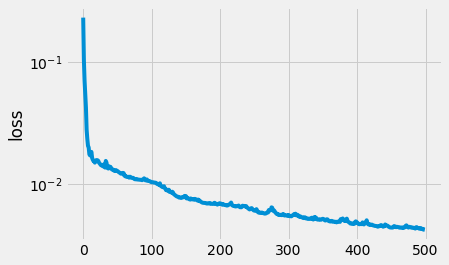

In [12]:
best_model = None
best_history = None
best_rmse = np.inf
best_prediction = None

for i in range(1, 10):
    print(f'model {i} of 10')
    history, model = create_model()
    yPred, yTest = predict_model(model, test_data)
    rmse = evaluate_model(yPred, yTest)
    print(rmse)
    if  rmse < best_rmse:
        best_model = model
        best_history = history
        best_rmse = rmse
        best_prediction = yPred

# Create dataframe of predicted data
prediction = pd.DataFrame(data=best_prediction, columns=users_df.columns[1:])
prediction['time_hour'] = users_df[train_data_len:]['time_hour'].values


plot_model_loss(best_history)

best_rmse



In [13]:
prediction.to_csv(f'../data/forecasting/users/lstm_prediction_{window}.csv', index=False)

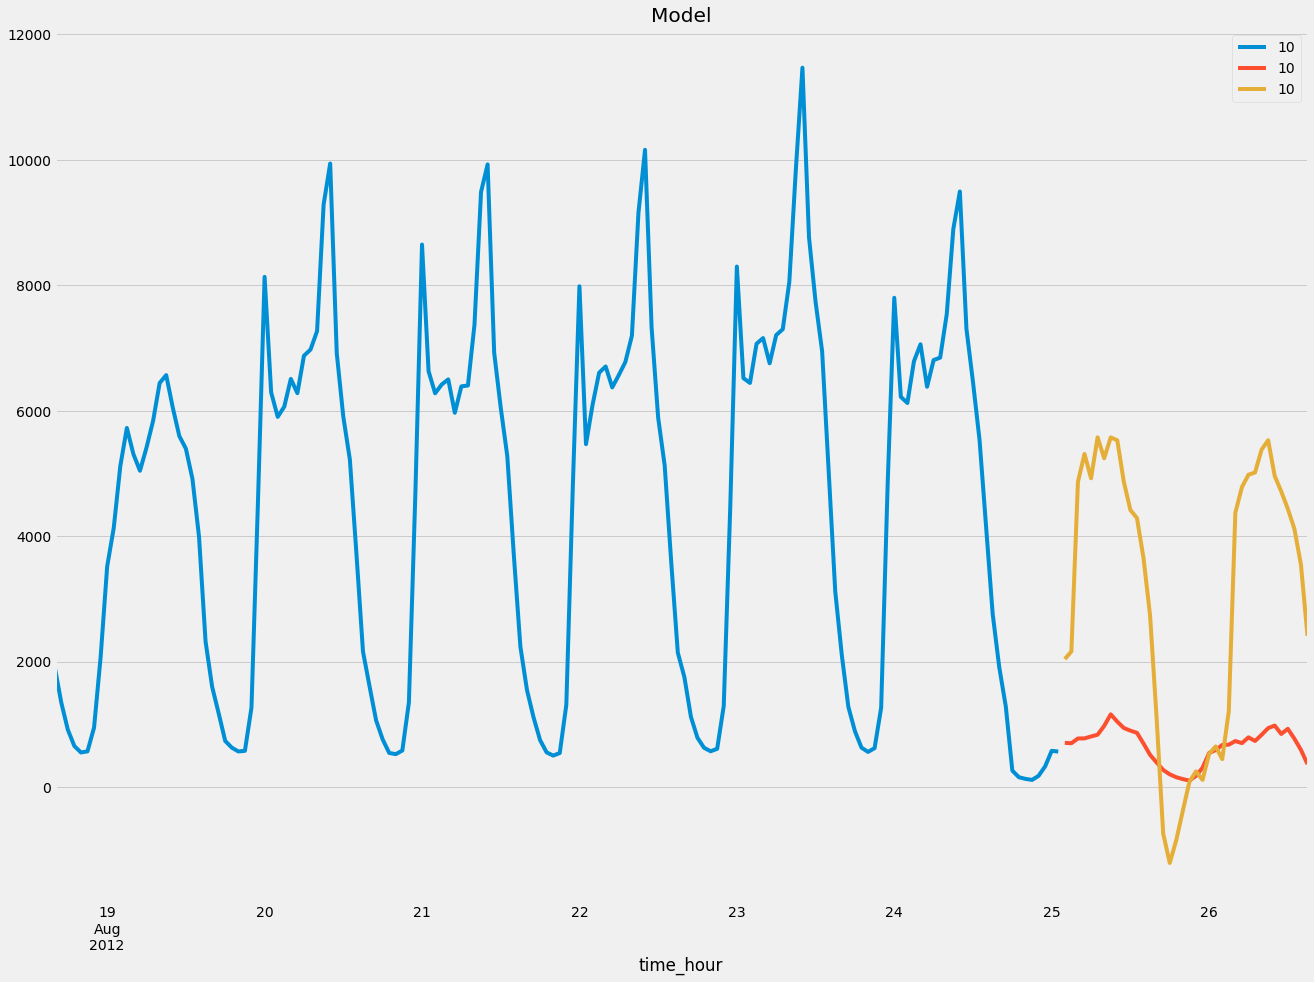

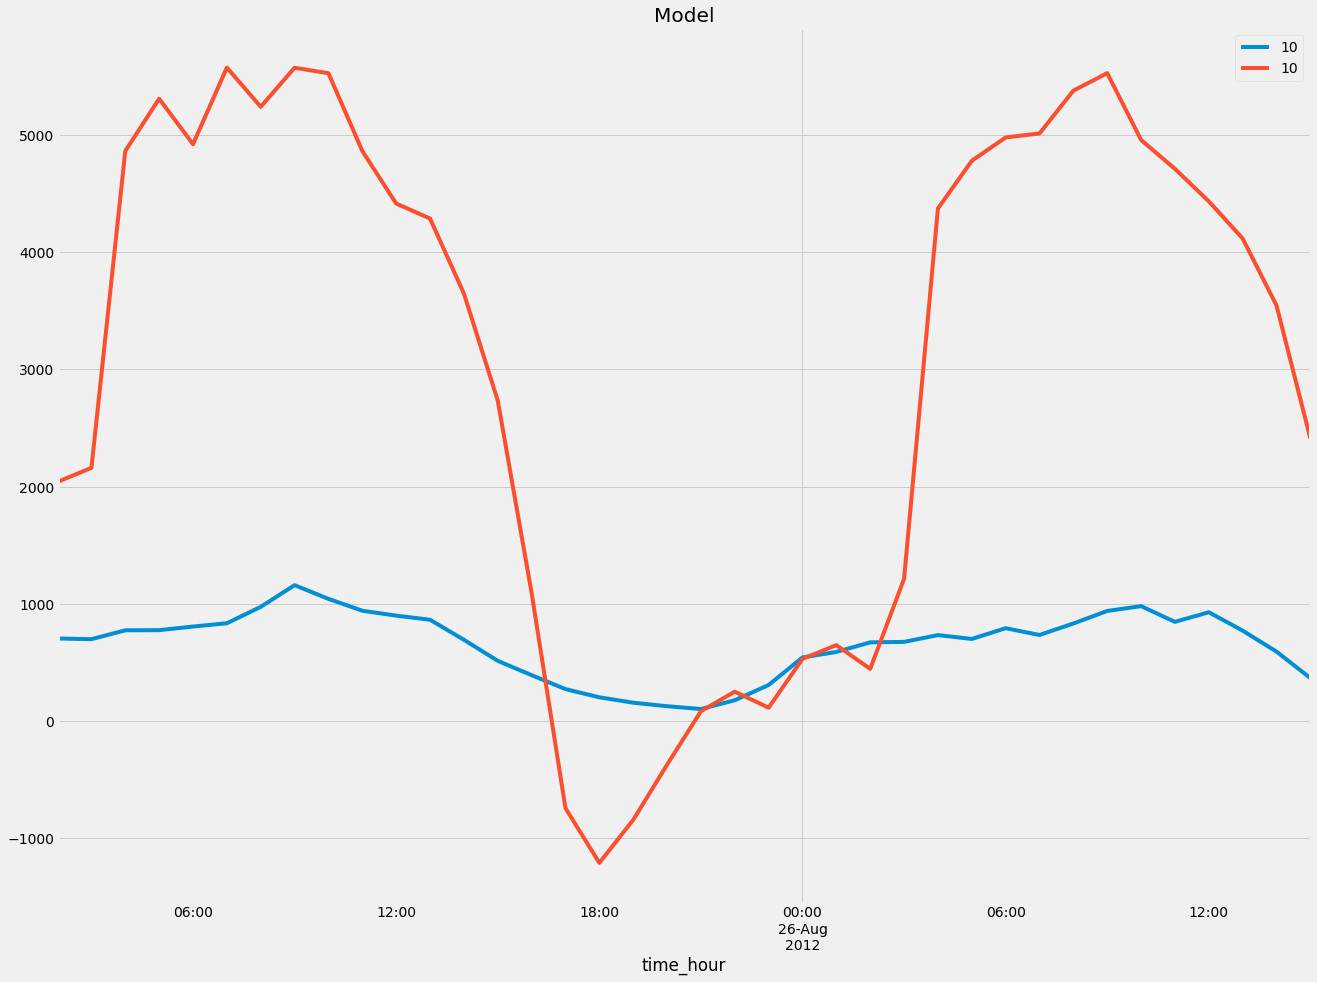

In [14]:
bs = "10"

plot_model(prediction, bs)
plot_prediction(prediction, bs)

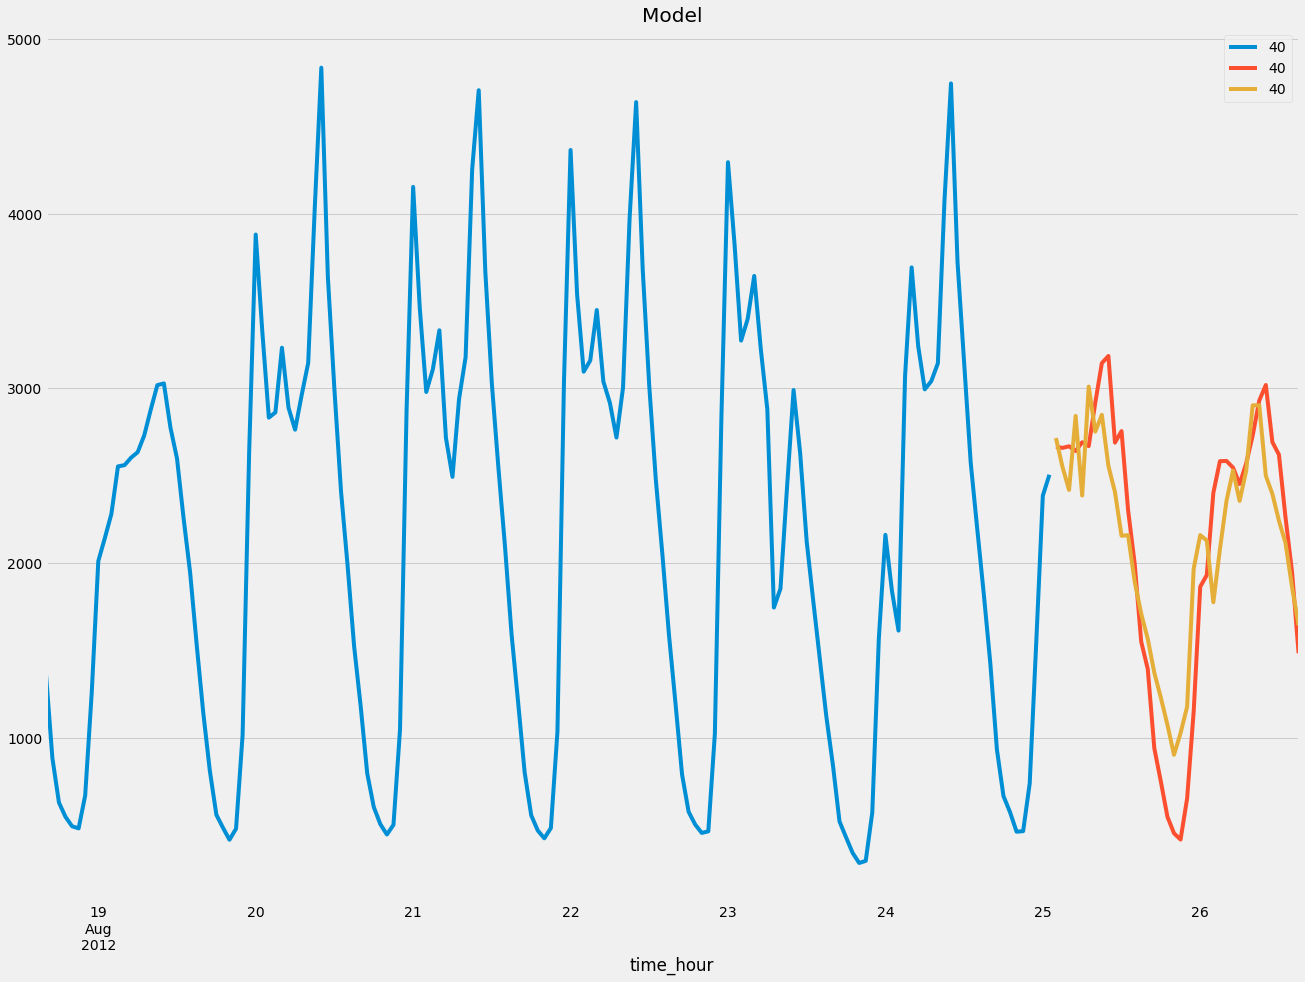

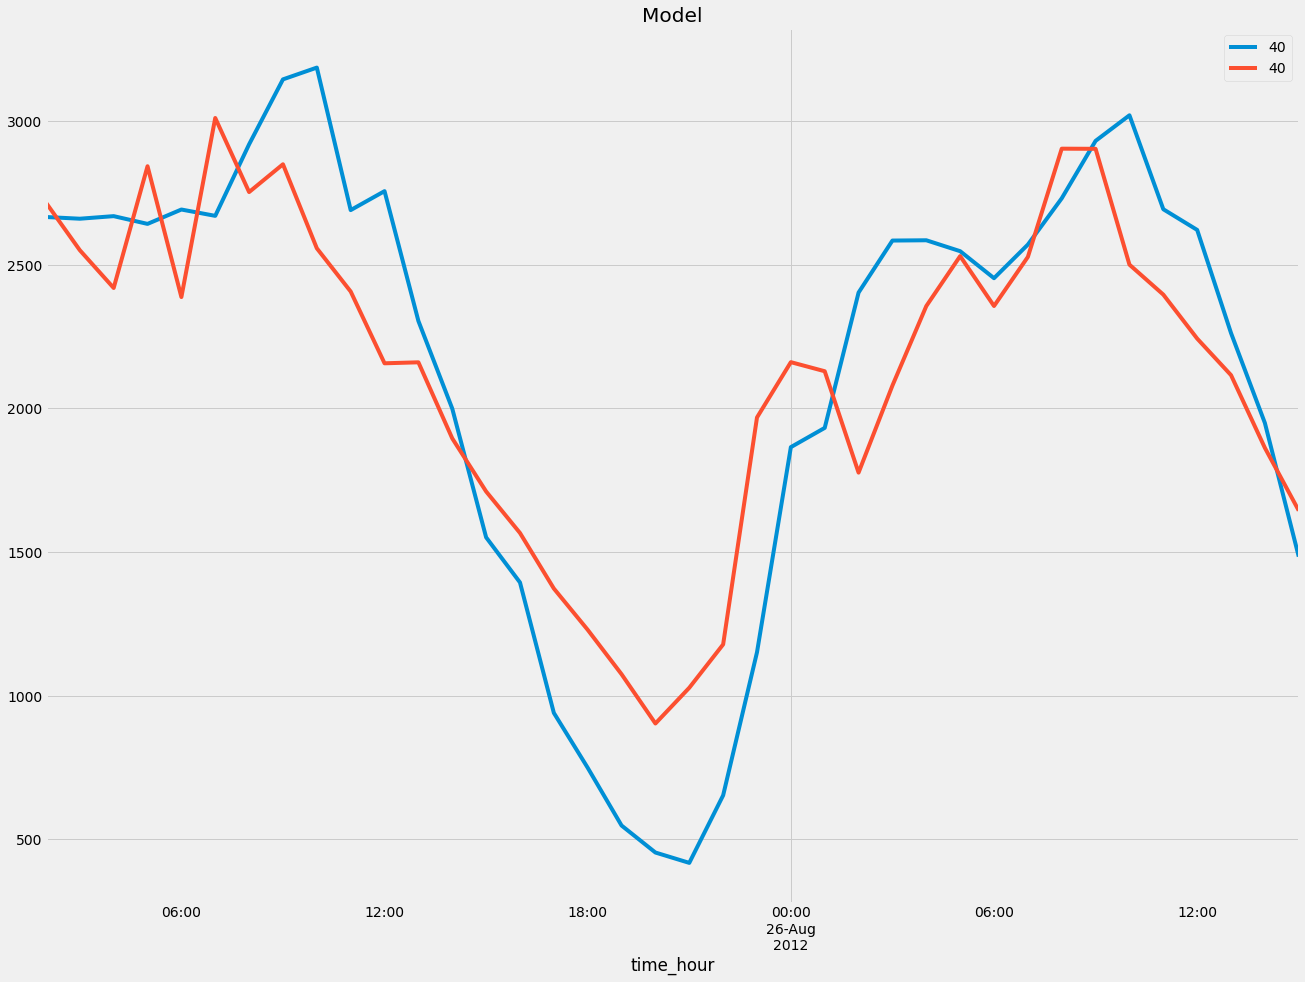

In [15]:
bs = "40"

plot_model(prediction, bs)
plot_prediction(prediction, bs)